In [1]:
# prapare packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Prepare data distributions

In [2]:
# true data distribution: p_d(x)
class DataDistribution(object):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    def sample(self, N):
        samples = np.random.normal(self.mu, self.sigma, N)
        #samples.sort()
        return samples

In [3]:
# p_z(z)
class NoiseDistribution(object):
    def __init__(self, range):
        self.range = range

    # equally spaced samples + noise
    def sample(self, N):
        offset = np.random.random(N) * (float(self.range) / N)
        samples = np.linspace(-self.range, self.range, N) + offset
        return samples

# Define layers to train

In [4]:
# define network layer that we will use for discriminator - D
def discriminator_layer(inputs, n_hidden=32):
    w_initializer = tf.truncated_normal_initializer(stddev=0.01)
    
    # 1st layer
    w0 = tf.get_variable("w0", [inputs.get_shape()[1], n_hidden], initializer=w_initializer)
    b0 = tf.get_variable("b0", [n_hidden], initializer=tf.constant_initializer(0.0))
    l0 = tf.nn.relu(tf.matmul(inputs, w0) + b0)
    
    # 2nd layer
    w1 = tf.get_variable("w1", [n_hidden, n_hidden], initializer=w_initializer)
    b1 = tf.get_variable("b1", [n_hidden], initializer=tf.constant_initializer(0.0))
    l1 = tf.nn.relu(tf.matmul(l0, w1) + b1)
    
    # output layer
    w2 = tf.get_variable("w2", [n_hidden, 1], initializer=w_initializer)
    b2 = tf.get_variable("b2", [1], initializer=tf.constant_initializer(0.0))
    lo = tf.matmul(l1, w2) + b2
    
    return lo

In [5]:
# define network layer that we will use for generator - G
def generator_layer(inputs, n_hidden=32):
    w_initializer = tf.truncated_normal_initializer(stddev=0.01)
    
    # 1st layer
    w0 = tf.get_variable("w0", [inputs.get_shape()[1], n_hidden], initializer=w_initializer)
    b0 = tf.get_variable("b0", [n_hidden], initializer=tf.constant_initializer(0.0))
    l0 = tf.nn.relu(tf.matmul(inputs, w0) + b0)
    
    # 2nd layer
    w1 = tf.get_variable("w1", [n_hidden, n_hidden], initializer=w_initializer)
    b1 = tf.get_variable("b1", [n_hidden], initializer=tf.constant_initializer(0.0))
    l1 = tf.nn.relu(tf.matmul(l0, w1) + b1)
    
    # output layer
    w2 = tf.get_variable("w2", [n_hidden, 1], initializer=w_initializer)
    b2 = tf.get_variable("b2", [1], initializer=tf.constant_initializer(0.0))
    lo = tf.sigmoid( tf.matmul(l1, w2) + b2 )
    
    return lo

In [6]:
def optimizer(loss, var_list, num_decay_steps=400, initial_learning_rate=0.03):
    decay = 0.95
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        initial_learning_rate,
        batch,
        num_decay_steps,
        decay,
        staircase=True
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss,
        global_step=batch,
        var_list=var_list
    )
    return optimizer

# The parameters

In [7]:
# number of samples to draw
N = 1000

# number of bins when computing histogram
n_bins = N//10

# mu & sigma for nomal distribution
mu, sigma = 0, 1

# Take a look at sample distribution a bit

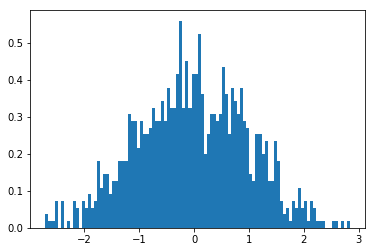

In [8]:
# the probability distribution(gaussian) for discriminator D's input
# draw N sample of p_d
p_d = DataDistribution(mu, sigma)
p_d_sample = p_d.sample(N)
plot_hist, _, __ = plt.hist(p_d_sample, bins=n_bins, normed=True)

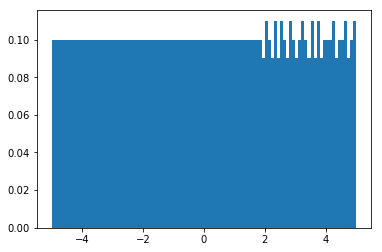

In [9]:
# the probability distribution(uniform) for generator G's input
data_range = 5
p_z = NoiseDistribution(data_range)
p_z_sample = p_z.sample(N)
plot_hist, _, __ = plt.hist(p_z_sample, bins=n_bins, normed=True)

# Build network

In [10]:
learning_rate = 0.01

### Pre-training

In [11]:
# pre training graph
with tf.variable_scope('D-pre'):
    inputs_pre = tf.placeholder(tf.float32, shape=[None, 1], name='inputs')
    targets_pre = tf.placeholder(tf.float32, shape=[None, 1], name='targets')
    D_pre = discriminator_layer(inputs_pre)
    
    # loss
    loss_pre = tf.reduce_mean(tf.square(D_pre - targets_pre))
    
    # optimizer
    t_vars = tf.trainable_variables()
    optimizer_pre = optimizer(loss_pre, t_vars, 400, learning_rate)

### Generator

In [12]:
with tf.variable_scope('G'):
    z = tf.placeholder(tf.float32, shape=[None, 1], name='inputs')
    G = generator_layer(z)

### Discriminator

In [13]:
with tf.variable_scope('D') as scope:
    x = tf.placeholder(tf.float32, shape=[None, 1], name='inputs')
    D_real = discriminator_layer(x)
    scope.reuse_variables()
    D_fake = discriminator_layer(G)

In [14]:
eps = 1e-2  # to prevent log(0) case
loss_G = tf.reduce_mean(-tf.log(D_fake + eps))
loss_D = tf.reduce_mean(-tf.log(D_real + eps) - tf.log(1 - D_fake + eps))

params_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='G')
params_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='D')

optimizer_G = optimizer(loss_G, params_G, 400, learning_rate * 0.5)
optimizer_D = optimizer(loss_D, params_D, 400, learning_rate)

# Pre-train decision surface
* If decider is reasonably accurate to start, we get much faster convergence.

In [15]:
n_pre_train = 1000

In [16]:
# normalize data distribution
def normalize_data(hist_density, edges):
    x = edges[1:]
    
    # will make [0 ~ 1]
    max_hist = np.max(hist_density)
    min_hist = np.min(hist_density)
    normed_y = (hist_density - min_hist) / (max_hist - min_hist)
    
    return x, normed_y

In [17]:
# open session and initialize all variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [18]:
# pre-training discriminator
for i in range(n_pre_train):
    drawn_samples = p_d.sample(N)
    hist_density, edges = np.histogram(drawn_samples, bins=n_bins, density=True)
    x, y = normalize_data(hist_density, edges)

    # Execute one training step
    fd = {inputs_pre: np.reshape(x, (n_bins, 1)), 
          targets_pre: np.reshape(y, (n_bins, 1))}
    loss_out, _ = sess.run([loss_pre, optimizer_pre], feed_dict=fd)
    
    if i % 10 == 0:
        print('pre-training :  {}/{}, cost: {:.4f}'.format(i, n_pre_train, loss_out))
print('pre-training finished!')

pre-training :  0/1000, cost: 0.1709
pre-training :  10/1000, cost: 0.1396
pre-training :  20/1000, cost: 0.1087
pre-training :  30/1000, cost: 0.0985
pre-training :  40/1000, cost: 0.0780
pre-training :  50/1000, cost: 0.0996
pre-training :  60/1000, cost: 0.0982
pre-training :  70/1000, cost: 0.1034
pre-training :  80/1000, cost: 0.0898
pre-training :  90/1000, cost: 0.0782
pre-training :  100/1000, cost: 0.0827
pre-training :  110/1000, cost: 0.0649
pre-training :  120/1000, cost: 0.0820
pre-training :  130/1000, cost: 0.0974
pre-training :  140/1000, cost: 0.1006
pre-training :  150/1000, cost: 0.0795
pre-training :  160/1000, cost: 0.0859
pre-training :  170/1000, cost: 0.0936
pre-training :  180/1000, cost: 0.0828
pre-training :  190/1000, cost: 0.0886
pre-training :  200/1000, cost: 0.0611
pre-training :  210/1000, cost: 0.0740
pre-training :  220/1000, cost: 0.0782
pre-training :  230/1000, cost: 0.0714
pre-training :  240/1000, cost: 0.0947
pre-training :  250/1000, cost: 0.08

In [19]:
# store pre-trained variables
params_pre = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='D-pre')
weights_D_pre = sess.run(params_pre)

### Time to train

In [20]:
n_train = 3000

# batch size
M = 150

In [24]:
# copy weights from pre-training over to new D network
tf.global_variables_initializer().run()
print(len(params_D))
print(len(params_G))
print(len(weights_D_pre))
for i, v in enumerate(params_D):
    sess.run(v.assign(weights_D_pre[i]))

13
6
7


IndexError: list index out of range

In [ ]:
# training-loop
for i in range(n_train):
    np.random.seed(np.random.randint(0, n_train))

    # update discriminator
    x_ = p_d.sample(M)
    z_ = p_z.sample(M)
    
    fd_D = {x: np.reshape(x_, (M, 1)), z: np.reshape(z_, (M, 1))}
    loss_out_D, _ = sess.run([loss_D, optimizer_D], feed_dict=fd_D)

    # update generator
    z_ = p_z.sample(M)
    fd_G = {z: np.reshape(z_, (B, 1))}
    loss_out_G, _ = sess.run([loss_G, optimizer_G], feed_dict=fd_G)

    if i % 10 == 0:
        print('[{}/{}]: loss_d : {:.3f}, loss_g : {.3f}'.format(i, n_train, loss_out_D, loss_out_G))